In [1]:
# Install necessary libraries (Kaggle has most, but ensuring)
!pip install torch torchvision pandas matplotlib seaborn scikit-learn pillow requests

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import requests
from io import BytesIO

In [3]:
# Load styles.csv
data_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv'
df = pd.read_csv(data_path, on_bad_lines='skip')  # Skip bad lines if any

# Display basic info
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())


      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column         

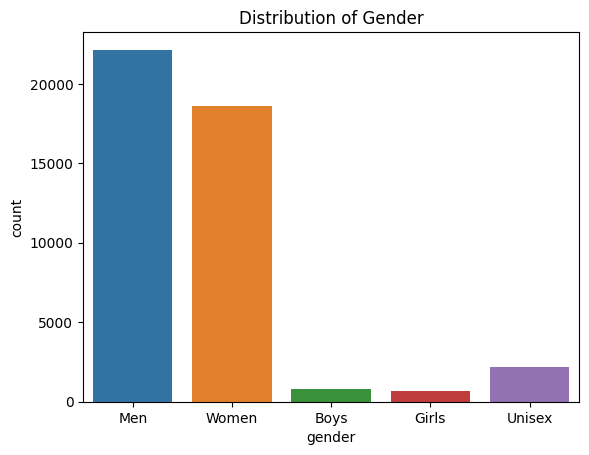

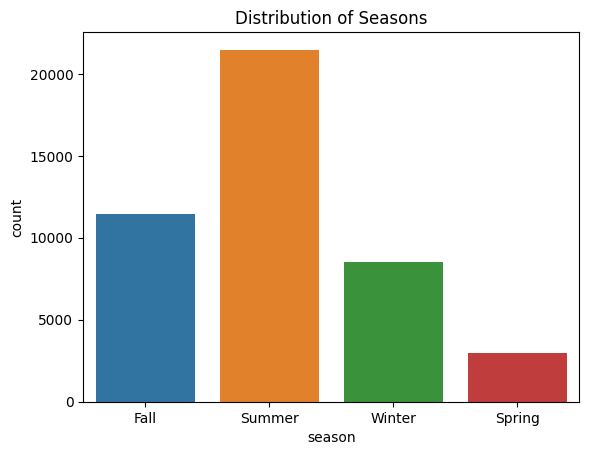

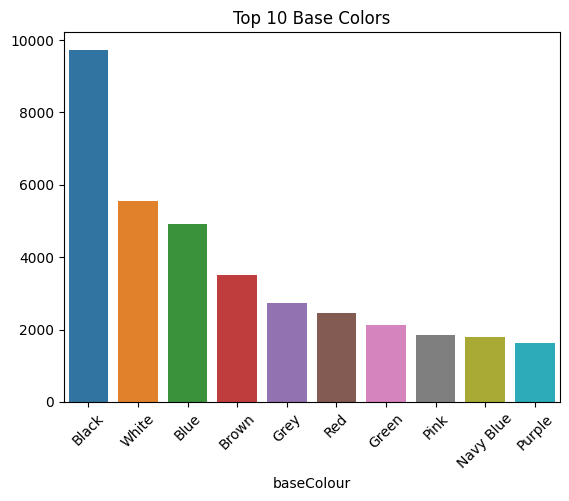

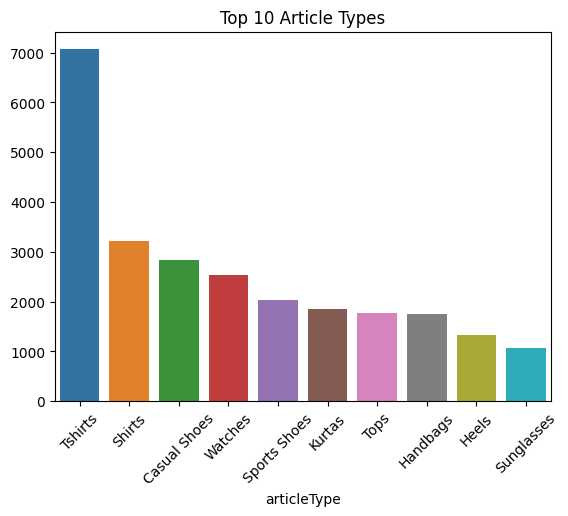

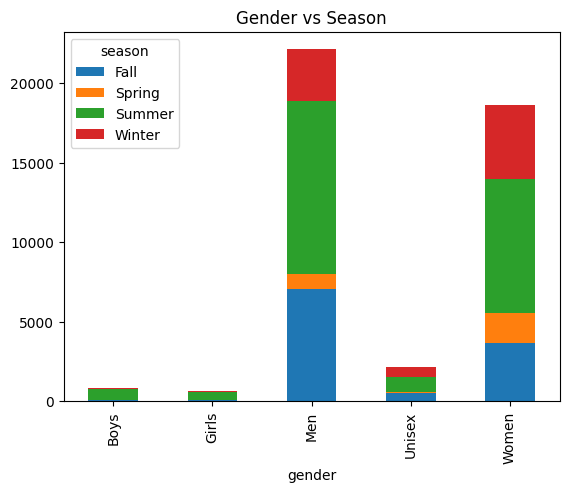

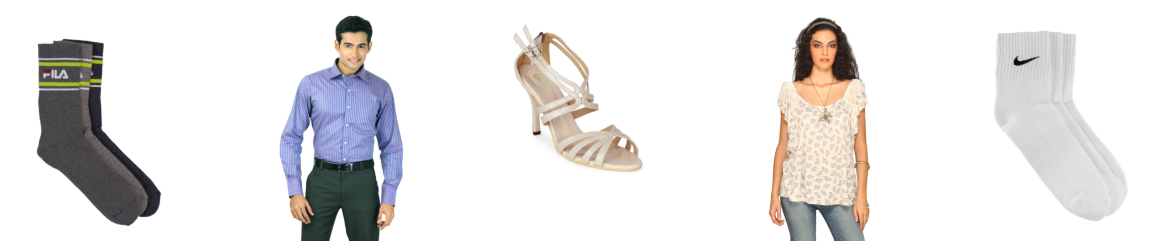

In [4]:
# Distribution of genders
sns.countplot(x='gender', data=df)
plt.title('Distribution of Gender')
plt.show()

# Distribution of seasons
sns.countplot(x='season', data=df)
plt.title('Distribution of Seasons')
plt.show()

# Distribution of base colors (top 10)
top_colors = df['baseColour'].value_counts().nlargest(10)
sns.barplot(x=top_colors.index, y=top_colors.values)
plt.title('Top 10 Base Colors')
plt.xticks(rotation=45)
plt.show()

# Distribution of article types (top 10)
top_types = df['articleType'].value_counts().nlargest(10)
sns.barplot(x=top_types.index, y=top_types.values)
plt.title('Top 10 Article Types')
plt.xticks(rotation=45)
plt.show()

# Correlation between categories (e.g., gender and season)
pd.crosstab(df['gender'], df['season']).plot(kind='bar', stacked=True)
plt.title('Gender vs Season')
plt.show()

# Image sample visualization
image_folder = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'
sample_images = df['id'].sample(5).values
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, img_id in enumerate(sample_images):
    img_path = os.path.join(image_folder, f"{img_id}.jpg")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
plt.show()


In [5]:
# Drop rows with missing critical labels
df = df.dropna(subset=['gender', 'baseColour', 'season', 'articleType'])
sampled_df = df.sample(n=5000, random_state=42).reset_index(drop=True)

# Encode labels
le_gender = LabelEncoder()
le_color = LabelEncoder()
le_season = LabelEncoder()
le_type = LabelEncoder()

sampled_df['gender_encoded'] = le_gender.fit_transform(sampled_df['gender'])
sampled_df['color_encoded'] = le_color.fit_transform(sampled_df['baseColour'])
sampled_df['season_encoded'] = le_season.fit_transform(sampled_df['season'])
sampled_df['type_encoded'] = le_type.fit_transform(sampled_df['articleType'])

# Number of classes
num_genders = len(le_gender.classes_)
num_colors = len(le_color.classes_)
num_seasons = len(le_season.classes_)
num_types = len(le_type.classes_)

print(f"Classes: Genders={num_genders}, Colors={num_colors}, Seasons={num_seasons}, Types={num_types}")

# Train-test split (80/20 split on sampled data)
train_df, test_df = train_test_split(sampled_df, test_size=0.2, random_state=42)

# Optional: Print shapes to verify
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")


Classes: Genders=5, Colors=44, Seasons=4, Types=119
Train shape: (4000, 14), Test shape: (1000, 14)


In [6]:
class FashionDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, f"{row['id']}.jpg")
        if not os.path.exists(img_path):
            return self.__getitem__((idx + 1) % len(self))  # Skip missing images
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        labels = {
            'gender': torch.tensor(row['gender_encoded'], dtype=torch.long),
            'color': torch.tensor(row['color_encoded'], dtype=torch.long),
            'season': torch.tensor(row['season_encoded'], dtype=torch.long),
            'type': torch.tensor(row['type_encoded'], dtype=torch.long)
        }
        return image, labels


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FashionDataset(train_df, image_folder, transform)
test_dataset = FashionDataset(test_df, image_folder, transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [8]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_genders, num_colors, num_seasons, num_types):
        super(MultiTaskModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()  # Remove final layer
        
        # Task-specific heads
        self.gender_head = nn.Linear(num_features, num_genders)
        self.color_head = nn.Linear(num_features, num_colors)
        self.season_head = nn.Linear(num_features, num_seasons)
        self.type_head = nn.Linear(num_features, num_types)
    
    def forward(self, x):
        features = self.base_model(x)
        return {
            'gender': self.gender_head(features),
            'color': self.color_head(features),
            'season': self.season_head(features),
            'type': self.type_head(features)
        }

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskModel(num_genders, num_colors, num_seasons, num_types).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches per epoch: {len(train_loader)}")

Number of training samples: 4000
Number of batches per epoch: 32


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = 0
        for task in ['gender', 'color', 'season', 'type']:
            loss += criterion(outputs[task], labels[task].to(device))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Save model
torch.save(model.state_dict(), 'fashion_model.pth')


Epoch 1, Loss: 5.932950541377068
Epoch 2, Loss: 4.039891943335533
Epoch 3, Loss: 3.285070985555649
Epoch 4, Loss: 2.7979660630226135
Epoch 5, Loss: 2.450035586953163


In [11]:
model.eval()
all_preds = {task: [] for task in ['gender', 'color', 'season', 'type']}
all_labels = {task: [] for task in ['gender', 'color', 'season', 'type']}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        for task in all_preds:
            preds = torch.argmax(outputs[task], dim=1).cpu().numpy()
            all_preds[task].extend(preds)
            all_labels[task].extend(labels[task].numpy())

for task in all_preds:
    acc = accuracy_score(all_labels[task], all_preds[task])
    print(f"{task.capitalize()} Accuracy: {acc}")
    print(classification_report(all_labels[task], all_preds[task]))


Gender Accuracy: 0.838
              precision    recall  f1-score   support

           0       0.92      0.57      0.71        21
           1       0.00      0.00      0.00        15
           2       0.90      0.85      0.87       502
           3       0.42      0.42      0.42        48
           4       0.81      0.92      0.86       414

    accuracy                           0.84      1000
   macro avg       0.61      0.55      0.57      1000
weighted avg       0.83      0.84      0.83      1000

Color Accuracy: 0.575
              precision    recall  f1-score   support

           0       0.26      0.48      0.34        25
           1       0.77      0.76      0.77       231
           2       0.50      0.81      0.62       106
           3       0.00      0.00      0.00         2
           4       0.67      0.38      0.48        80
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         3
           8       0.00      0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [12]:
# Sample Amazon image URLs (replace with real screenshots)
sample_urls = [
    'https://m.media-amazon.com/images/I/61LunrukImL._AC_SY445_.jpg',  # T-shirt example
    'https://m.media-amazon.com/images/I/71-crYIBnjL._AC_SX395_.jpg'     # Shoes example
]

def predict_image(url, model, transform, le_dict):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
    
    preds = {}
    for task, le in le_dict.items():
        pred_idx = torch.argmax(outputs[task], dim=1).item()
        preds[task] = le.inverse_transform([pred_idx])[0]
    
    return preds

le_dict = {
    'gender': le_gender,
    'color': le_color,
    'season': le_season,
    'type': le_type
}

for url in sample_urls:
    preds = predict_image(url, model, transform, le_dict)
    print(f"Predictions for {url}: {preds}")


Predictions for https://m.media-amazon.com/images/I/61LunrukImL._AC_SY445_.jpg: {'gender': 'Men', 'color': 'White', 'season': 'Summer', 'type': 'Innerwear Vests'}
Predictions for https://m.media-amazon.com/images/I/71-crYIBnjL._AC_SX395_.jpg: {'gender': 'Men', 'color': 'Black', 'season': 'Winter', 'type': 'Jackets'}
